In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split

Należy odpowiednio ustawić ścieżki do struktury projektu. My w tym przypadku z powodu braku wystarczającym mocy obliczeniowych pracowaliśmy w Google Colabe

In [ ]:
# --- 1. KONFIGURACJA ŚRODOWISKA (GOOGLE COLAB) ---
# Montowanie Dysku Google
drive.mount('/content/drive')

# DEFINICJA ŚCIEŻEK
# Ustawiamy ścieżkę do głównego folderu projektu na Dysku Google.
# Ścieżka do miejsca na dysku w którym są dane.
PROJECT_ROOT = Path('/content/drive/MyDrive/FF_MOTOR_PROJECT')

# Wskazujemy folder z danymi zgodnie z strukturą projektu
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_FILE = DATA_DIR / 'final_data.csv'

# Weryfikacja
if not DATA_DIR.exists():
    print(f"BŁĄD: Nie znaleziono folderu: {DATA_DIR}")
    print("Upewnij się, że folder 'FF_MOTOR_PROJECT' znajduje się bezpośrednio na 'Moim Dysku'.")
else:
    print(f"Folder danych znaleziony: {DATA_DIR}")

# --- 2. GŁÓWNA LOGIKA (ETL) ---

# Sprawdzenie czy plik wynikowy już istnieje
if OUTPUT_FILE.exists():
    print(f"Plik {OUTPUT_FILE.name} już istnieje. Wczytuję gotowe dane.")
    merged = pd.read_csv(OUTPUT_FILE)
else:
    print(f"Plik {OUTPUT_FILE.name} nie istnieje. Rozpoczynam przetwarzanie...")

    try:
        # 1. WCZYTYWANIE DANYCH
        data = pd.read_csv(DATA_DIR / 'setpoints.csv')
        data.rename(columns={'value': 'setpoint_fr', 'value2':'setpoint_rl', 'value3' : 'setpoint_rr'}, inplace=True)

        data2 = pd.read_csv(DATA_DIR / 'fsp_endu_current.csv')
        data2.rename(columns={'value': 'current', 'value2':'voltage'}, inplace=True)

        def load_wheel_data(filename, col_name):
            df = pd.read_csv(DATA_DIR / filename).drop(columns=['topic', 'timestamp'])
            df.rename(columns={'value': col_name}, inplace=True)
            df[col_name] = abs(df[col_name])
            return df

        data_fr = load_wheel_data('front_right_data.csv', 'speed_fr')
        data_rl = load_wheel_data('rear_left_data.csv', 'speed_rl')
        data_rr = load_wheel_data('rear_right_data.csv', 'speed_rr')

        # 2. ŁĄCZENIE I SYNCHRONIZACJA
        merged_wheels = pd.merge_asof(data_fr.sort_values('elapsed time'),
                                      data_rl.sort_values('elapsed time'),
                                      on='elapsed time', direction='nearest', tolerance=0.1)
        merged_wheels = pd.merge_asof(merged_wheels,
                                      data_rr.sort_values('elapsed time'),
                                      on='elapsed time', direction='nearest', tolerance=0.1)
        merged_wheels.interpolate(method='linear', inplace=True)

        # Scalanie wszystkiego
        merged = pd.merge_asof(data.sort_values('elapsed time'),
                               data2.sort_values('elapsed time'),
                               on='elapsed time', direction='nearest', tolerance=0.1)
        merged = pd.merge_asof(merged, merged_wheels, on='elapsed time', direction='nearest', tolerance=0.1)

        # 3. CZYSZCZENIE I INŻYNIERIA CECH
        merged['power'] = merged['voltage'] * merged['current']
        merged.drop(columns=['elapsed time', 'voltage', 'current'], inplace=True)
        merged.dropna(inplace=True)
        merged = merged[merged['power'] >= 0]

        # 4. ZAPIS WYNIKU
        merged.to_csv(OUTPUT_FILE, index=False)
        print(f"Sukces! Nowy plik zapisany w: {OUTPUT_FILE}")

    except FileNotFoundError as e:
        print(f"BŁĄD KRYTYCZNY: Nie znaleziono pliku źródłowego. Sprawdź nazwy plików w folderze data.\nSzczegóły: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder danych znaleziony: /content/drive/MyDrive/FF_MOTOR_PROJECT/data
Plik final_data.csv już istnieje. Wczytuję gotowe dane.


In [ ]:
# --- 3. PRZYGOTOWANIE DO MODELU (SPLIT) ---

if 'merged' in locals():
    # Wybór cech i celu
    features = ['setpoint_fr', 'setpoint_rl', 'setpoint_rr',
                'speed_fr', 'speed_rl', 'speed_rr']
    target = 'power'

    X = merged[features]
    y = merged[target]

    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Weryfikacja
    print("\n--- PODSUMOWANIE DANYCH ---")
    print(f"Liczba próbek treningowych: {X_train.shape[0]}")
    print(f"Liczba próbek testowych:    {X_test.shape[0]}")
    print(f"Ścieżka zapisu: {OUTPUT_FILE}")
else:
    print("Brak danych w zmiennej 'merged'. Sprawdź błędy powyżej.")


--- PODSUMOWANIE DANYCH ---
Liczba próbek treningowych: 41441
Liczba próbek testowych:    10361
Ścieżka zapisu: /content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv


In [ ]:
# Upewniamy się, że mamy zmienne
if 'X_train' not in locals():
    print("Uruchom najpierw poprzednią sekcję z podziałem danych (train_test_split)!")
else:
    # 1. Skalowanie wejść (X) - sprowadzamy prędkości i setpointy do wspólnego zakresu
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    # 2. Skalowanie wyjścia (y)
    # Reshape(-1, 1) jest potrzebny, bo skaler oczekuje macierzy 2D
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

    print("Dane przeskalowane i gotowe do treningu.")
    print(f"Kształt wejścia: {X_train_scaled.shape}")

Dane przeskalowane i gotowe do treningu.
Kształt wejścia: (41441, 6)


In [ ]:
# 1. Definicja modelu
model = keras.Sequential([
    # Warstwa wejściowa
    layers.Input(shape=(X_train.shape[1],)),
    # Pierwsza warstwa ukryta (64 neurony)
    layers.Dense(64, activation='relu'),
    # Druga warstwa ukryta (32 neurony) - łapie zależności nieliniowe
    layers.Dense(32, activation='relu'),
    # Warstwa wyjściowa (1 neuron = przewidywana Moc)
    layers.Dense(1)
])

# 2. Kompilacja
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# 3. Trening
print("Rozpoczynam trening (50 epok)...")
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # 20% treningu używamy do podglądu postępów
    verbose=1
)
print("Trening zakończony.")

Rozpoczynam trening (50 epok)...
Epoch 1/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0663 - mae: 0.1347 - val_loss: 0.0267 - val_mae: 0.0919
Epoch 2/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0272 - mae: 0.0865 - val_loss: 0.0266 - val_mae: 0.0941
Epoch 3/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0255 - mae: 0.0843 - val_loss: 0.0264 - val_mae: 0.1031
Epoch 4/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0255 - mae: 0.0860 - val_loss: 0.0265 - val_mae: 0.0904
Epoch 5/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0255 - mae: 0.0838 - val_loss: 0.0244 - val_mae: 0.0834
Epoch 6/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0258 - mae: 0.0833 - val_loss: 0.0258 - val_mae: 0.0974
Epoch 7/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0256 - mae: 0.0841 - val_loss: 0.0235 - val_mae: 0.0783
Epoch 8/50
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0242 - mae: 0.0808 - val_loss: 0.0232 - val_mae: 0.0791
Epoch 9

324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

WYNIKI EWALUACJI:
Średni Błąd (MAE): 117916.20 W
Dopasowanie (R2):  0.9741 (Ideałem jest 1.0)


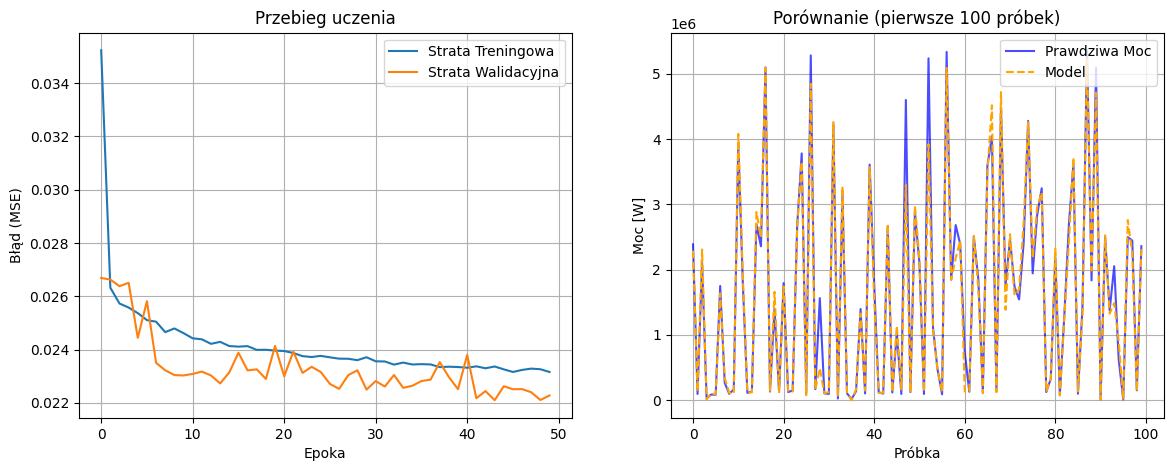

In [ ]:
# 1. Predykcja na zbiorze testowym
y_pred_scaled = model.predict(X_test_scaled)

# 2. Odwrócenie skalowania (powrót do Watów)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# 3. Metryki jakości
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nWYNIKI EWALUACJI:")
print(f"Średni Błąd (MAE): {mae:.2f} W")
print(f"Dopasowanie (R2):  {r2:.4f} (Ideałem jest 1.0)")

# 4. Wizualizacja
plt.figure(figsize=(14, 5))

# Wykres straty (czy model się uczył?)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata Treningowa')
plt.plot(history.history['val_loss'], label='Strata Walidacyjna')
plt.title('Przebieg uczenia')
plt.xlabel('Epoka')
plt.ylabel('Błąd (MSE)')
plt.legend()
plt.grid(True)

# Wykres Rzeczywistość vs Model (tylko 100 próbek dla czytelności)
plt.subplot(1, 2, 2)
limit = 100
plt.plot(y_test.values[:limit], label='Prawdziwa Moc', color='blue', alpha=0.7)
plt.plot(y_pred[:limit], label='Model', color='orange', linestyle='--')
plt.title(f'Porównanie (pierwsze {limit} próbek)')
plt.xlabel('Próbka')
plt.ylabel('Moc [W]')
plt.legend()
plt.grid(True)

plt.show()